In [2]:
from procgen_tools.utils import setup

setup() # create directory structure and download data 

In [19]:
from procgen_tools import maze, visualization, models
import wandb
from tqdm import tqdm
import torch
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Tuple
import pickle
import time
from sklearn.utils.extmath import randomized_svd

In [4]:
run_id = "jp9tjfzd"
project_name = "procgen"
api = wandb.Api()
run = api.run(f"{project_name}/{run_id}")

In [6]:
artifacts = run.logged_artifacts()
artifact = artifacts[8000]
artifact_dir = artifact.download()
model_file = os.path.join(artifact_dir, f"{artifact.name[:-3]}.pth")

wandb:   1 of 1 files downloaded.  


<class 'dict'>


In [39]:
def _tadd(*tups: List[Tuple[int, int]]):
    """Add a list of tuples elementwise."""
    return (list(sum(axis) for axis in zip(*tups)))

def save_artifact_locally(artifact_no, model_file, run_id = "jp9tjfzd", project_name = "procgen", verbose=False):
    if verbose:
        print("Downloading artifact...")
    api = wandb.Api()
    run = api.run(f"{project_name}/{run_id}")
    artifacts = run.logged_artifacts()
    artifact = artifacts[artifact_no]
    artifact_dir = artifact.download()
    if verbose:
        print("Moving artifact...")
    saved_location = os.path.join(artifact_dir, f"{artifact.name[:-3]}.pth")
    # making sure the destination directory exists
    os.makedirs(os.path.dirname(model_file), exist_ok=True)
    shutil.move(saved_location, model_file)
    if verbose:
        print("saved artifact to ", model_file)

def get_arrows(model_file, device=torch.device("cuda:0")):
    model = torch.load(model_file)
    if "state_dict" in model:
        model["model_state_dict"] = model.pop("state_dict")
    torch.save(model, model_file)
    model = models.load_policy(model_file, 15, torch.device(device))
    venv = maze.create_venv(1, start_level=0, num_levels=1)
    vf_original = visualization.vector_field(venv, model)
    arrows = np.array(vf_original["arrows"])
    arrows = np.array([_tadd(*arr_list) for arr_list in arrows])
    return arrows

In [30]:
model_file = "./models/8000"
# save_artifact_locally(8000, model_file, verbose=False)
arrows = get_arrows(model_file)
print(arrows.size)

960


In [15]:
flattened_arrows = arrows.reshape(arrows.size)
print(flattened_arrows.size)

192


In [40]:
num_models = 8000
count_by = 120
big_arrows = np.zeros((192, num_models))
timestamp = time.time()
for i in tqdm(range(0, num_models, count_by)):
    model_file = f"./models/model_{i}.pth"
    # check if model file already exists
    if not os.path.exists(model_file):
        save_artifact_locally(i, model_file, verbose=False)
    arrows = get_arrows(model_file)
    flattened_arrows = arrows.reshape(arrows.size)
    big_arrows[:, i] = flattened_arrows
os.makedirs(f"./data/{timestamp}", exist_ok=True)
with open(f"./data/{timestamp}/big_arrows.pkl", "wb") as f:
    pickle.dump(big_arrows, f)

100%|██████████| 67/67 [01:14<00:00,  1.11s/it]


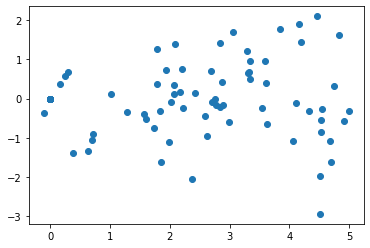

In [41]:
# perform svd on big_arrows
u, s, v = randomized_svd(big_arrows, n_components = 2)
sv_plot = u.T @ big_arrows
plt.scatter(sv_plot[0], sv_plot[1])
plt.show()

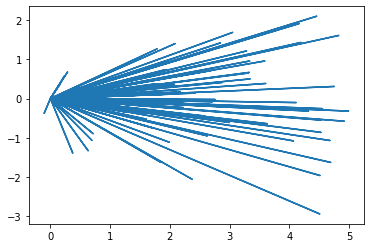

In [42]:
plt.plot(sv_plot[0], sv_plot[1])
plt.show()